In [1]:
import tensorflow as tf
from tensorflow import keras

2024-03-16 15:06:11.201280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 15:06:11.390049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-16 15:06:11.390066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-16 15:06:11.424665: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 15:06:12.361455: W tensorflow/stream_executor/platform/de

In [2]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import pandas as pd
import os

df=pd.read_csv(os.path.join(os.getcwd(), "..", "data",'eurousd.csv'))
df.head()

,date,time,open,high,low,close,volume
0,21/10/2002,01:05:00,0.97320,0.97325,0.97280,0.97285,0
1,21/10/2002,01:10:00,0.97300,0.97320,0.97300,0.97320,0
2,21/10/2002,01:15:00,0.97320,0.97320,0.97295,0.97310,0
3,21/10/2002,01:20:00,0.97315,0.97340,0.97270,0.97270,0
4,21/10/2002,01:25:00,0.97280,0.97295,0.97260,0.97260,0


In [4]:
df['date']=pd.to_datetime(df['date'])
df=df[df['date'].dt.year>2022]
df.head()

/tmp/ipykernel_251225/2811347094.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date']=pd.to_datetime(df['date'])


,date,time,open,high,low,close,volume
1530509,2023-01-01,18:00:00,1.07037,1.07042,1.07037,1.07042,5
1530510,2023-01-01,18:05:00,1.07043,1.07046,1.07043,1.07046,4
1530511,2023-01-01,18:10:00,1.07047,1.07053,1.07047,1.07052,6
1530512,2023-01-01,18:15:00,1.07048,1.07048,1.07028,1.07028,7
1530513,2023-01-01,18:20:00,1.07025,1.07025,1.07007,1.07007,10


In [5]:
df['PrevClose'] = df['close'].shift(1)
df.head()

,date,time,open,high,low,close,volume,PrevClose
1530509,2023-01-01,18:00:00,1.07037,1.07042,1.07037,1.07042,5,NaN
1530510,2023-01-01,18:05:00,1.07043,1.07046,1.07043,1.07046,4,1.07042
1530511,2023-01-01,18:10:00,1.07047,1.07053,1.07047,1.07052,6,1.07046
1530512,2023-01-01,18:15:00,1.07048,1.07048,1.07028,1.07028,7,1.07052
1530513,2023-01-01,18:20:00,1.07025,1.07025,1.07007,1.07007,10,1.07028


In [6]:
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df['mom']=df['close'].rolling(3).mean()
df.head()

,date,time,open,high,low,close,volume,PrevClose,Return,mom
1530509,2023-01-01,18:00:00,1.07037,1.07042,1.07037,1.07042,5,NaN,NaN,NaN
1530510,2023-01-01,18:05:00,1.07043,1.07046,1.07043,1.07046,4,1.07042,0.000037,NaN
1530511,2023-01-01,18:10:00,1.07047,1.07053,1.07047,1.07052,6,1.07046,0.000056,1.070467
1530512,2023-01-01,18:15:00,1.07048,1.07048,1.07028,1.07028,7,1.07052,-0.000224,1.070420
1530513,2023-01-01,18:20:00,1.07025,1.07025,1.07007,1.07007,10,1.07028,-0.000196,1.070290


In [7]:
input_data = df[['close', 'mom']][2:]
targets = df['Return'].values

In [8]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T
print(D)

2


In [9]:
Ntrain=int(len(input_data)*0.8)
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [10]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T]>0)

In [11]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T]>0 )

In [12]:
i = Input(shape=(T, D))
x = LSTM(50, dropout=0.2)(i)
x=keras.layers.Dropout(0.3)(x)
#x= Dense(10, activation='relu')(x)
#x=keras.layers.Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy'],
)

2024-03-16 15:06:16.890034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 15:06:16.890163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-16 15:06:16.890223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-03-16 15:06:16.890281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-03-16 15:06:16.890337: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [13]:
#es = EarlyStopping(patience=20, restore_best_weights=True)
#callbacks=[es],
history = model.fit(X_train, Y_train,
          validation_split=0.2,
          batch_size=32,
          epochs=40,

          verbose=1)

Epoch 1/40
1805/1805 [==============================] - 25s 13ms/step - loss: 0.6943 - accuracy: 0.5072 - val_loss: 0.6927 - val_accuracy: 0.5080
Epoch 2/40
1805/1805 [==============================] - 22s 12ms/step - loss: 0.6932 - accuracy: 0.5102 - val_loss: 0.6932 - val_accuracy: 0.5062
Epoch 3/40
1805/1805 [==============================] - 22s 12ms/step - loss: 0.6931 - accuracy: 0.5108 - val_loss: 0.6927 - val_accuracy: 0.5062
Epoch 4/40
1805/1805 [==============================] - 22s 12ms/step - loss: 0.6931 - accuracy: 0.5084 - val_loss: 0.6928 - val_accuracy: 0.5172
Epoch 5/40
1805/1805 [==============================] - 22s 12ms/step - loss: 0.6929 - accuracy: 0.5103 - val_loss: 0.6928 - val_accuracy: 0.5062
Epoch 6/40
1805/1805 [==============================] - 22s 12ms/step - loss: 0.6929 - accuracy: 0.5112 - val_loss: 0.6927 - val_accuracy: 0.5133
Epoch 7/40
1805/1805 [==============================] - 22s 12ms/step - loss: 0.6928 - accuracy: 0.5113 - val_loss: 0.6926 -

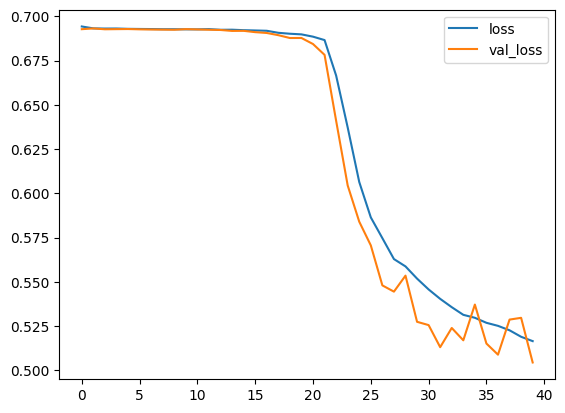

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

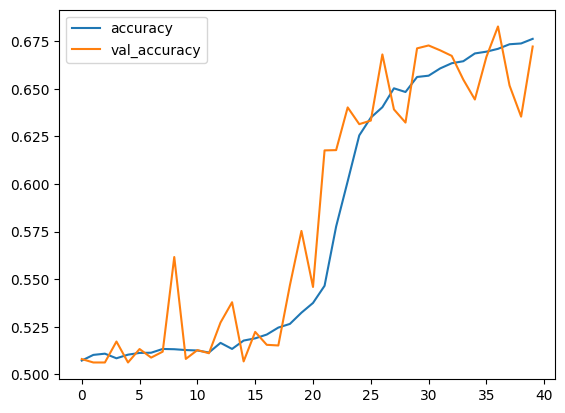

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [16]:
pred=model.predict(X_test)


564/564 [==============================] - 3s 4ms/step


In [17]:
lstm2=model.evaluate(X_test, Y_test)

564/564 [==============================] - 2s 4ms/step - loss: 0.2985 - accuracy: 0.8457


(array([2599.,  493.,  346.,  253.,  217.,  209.,  185.,  182.,  146.,
         146.,  137.,  145.,  188.,  131.,  149.,  175.,  149.,  169.,
         134.,  148.,  168.,  178.,  476., 2460.,  906.,  179.,  149.,
         138.,  147.,  139.,  149.,  152.,  140.,  127.,  158.,  154.,
         160.,  190.,  156.,  154.,  170.,  192.,  195.,  230.,  233.,
         253.,  243.,  372.,  564., 2805.]),
 array([5.10605502e-10, 2.00000014e-02, 3.99999991e-02, 5.99999987e-02,
        7.99999982e-02, 1.00000001e-01, 1.19999997e-01, 1.40000001e-01,
        1.59999996e-01, 1.80000007e-01, 2.00000003e-01, 2.19999999e-01,
        2.39999995e-01, 2.59999990e-01, 2.80000001e-01, 3.00000012e-01,
        3.19999993e-01, 3.40000004e-01, 3.60000014e-01, 3.79999995e-01,
        4.00000006e-01, 4.19999987e-01, 4.39999998e-01, 4.60000008e-01,
        4.79999989e-01, 5.00000000e-01, 5.19999981e-01, 5.40000021e-01,
        5.60000002e-01, 5.79999983e-01, 6.00000024e-01, 6.20000005e-01,
        6.39999986e-01, 

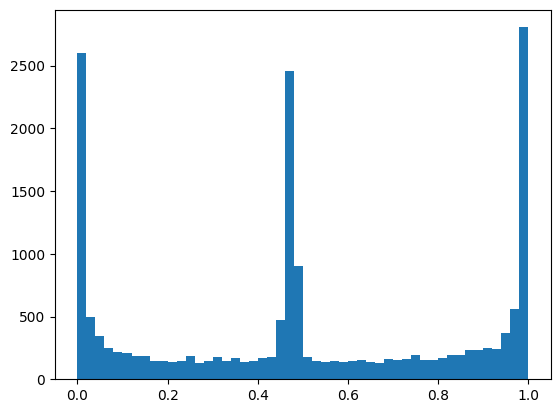

In [18]:
plt.hist(pred , bins=50)